In [1]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

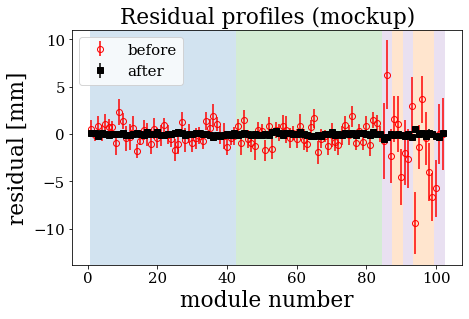

In [2]:
x = range(1, 84+18+1)
r = random.Random()
y = [r.gauss(0,1)*1 for i in range(84)]+[r.gauss(0,1)*3 for i in range(18)]
dy = [1+r.gauss(0,1)*.2 for i in range(84)]+[3+r.gauss(0,1)*.5 for i in range(18)]
plt.errorbar(x,y, dy,color='r', fillstyle='none', marker='o', linestyle='', label='before')

y = [r.gauss(0,1)*.1 for i in range(84)]+[r.gauss(0,1)*.3 for i in range(18)]
dy = [0.05+r.gauss(0,1)*.2 for i in range(84)]+[.2+r.gauss(0,1)*.1 for i in range(18)]
plt.errorbar(x,y, dy,color='k', fillstyle='full', marker='s', linestyle='', label='after')

plt.legend()
plt.gca().set_title("Residual profiles (mockup)")
plt.gca().set_ylabel("residual [mm]")
plt.gca().set_xlabel("module number")
plt.gca().axvspan(0.5, 42.5, facecolor='tab:blue', alpha=0.2)
plt.gca().axvspan(42.5, 84.5, facecolor='tab:green', alpha=0.2)
plt.gca().axvspan(84.5, 87.5, facecolor='tab:purple', alpha=0.2)
plt.gca().axvspan(87.5, 90.5, facecolor='tab:orange', alpha=0.2)
plt.gca().axvspan(90.5, 93.5, facecolor='tab:purple', alpha=0.2)
plt.gca().axvspan(93.5, 99.5, facecolor='tab:orange', alpha=0.2)
plt.gca().axvspan(99.5, 102.5, facecolor='tab:purple', alpha=0.2)
plt.savefig("mockup_profiles.pdf")

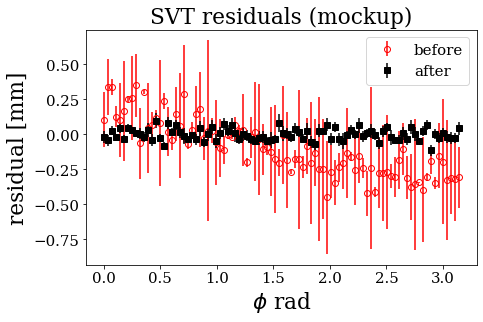

In [3]:
x = np.linspace(0, np.pi,90)
r1 = .3
y = r1*np.cos(x+.52)+[r.gauss(0,1)*.1 for i in range(90)]
dy = [.2+r.gauss(0,1)*.2 for i in range(90)]
plt.errorbar(x,y, dy,color='r', fillstyle='none', marker='o', linestyle='', label='before')
y = [r.gauss(0,1)*.04 for i in range(90)]
dy = [.04+r.gauss(0,1)*.01 for i in range(90)]
plt.errorbar(x,y, dy,color='k', fillstyle='full', marker='s', linestyle='', label='after')

plt.legend()
plt.gca().set_title("SVT residuals (mockup)")
plt.gca().set_ylabel("residual [mm]")
plt.gca().set_xlabel("$\phi$ rad")
plt.savefig("mockup_profiles_phi.pdf")

In [29]:
def blank_df(n):
    df = pd.DataFrame()
    for a in 'sector layer component deltaX deltaY deltaZ rotX rotY rotZ rotA'.split():
        df[a] = [0]*n
    return df

In [30]:
def get_df_from_ccdb(var, bank):
    import subprocess
    
    bashCmd = f"ccdb info {bank}".split()
    process = subprocess.Popen(bashCmd, stdout=subprocess.PIPE)
    info_output, error = process.communicate()
    lines = str(info_output).split('\\n')[15:]
    columns = []
    for line in lines:
        split = line.split()
        if len(split) ==4:
            columns.append(split[3])
    #print(columns)
    bashCmd = f"ccdb dump {bank} -v {var}".split()
    process = subprocess.Popen(bashCmd, stdout=subprocess.PIPE)
    dump_output, error = process.communicate()
    lines = str(dump_output).split("\\n")
    
    d = {col:[] for col in columns}
    for line in lines:
        #print(line)
        if not "#" in line and "'" not in line:
            for val,col in zip(line.split(),columns):
                d[col].append(float(val))
    df = pd.DataFrame(d)
    return df 

In [109]:
def get_df_from_file(filename):
    import subprocess
    columns = "sector layer component deltaX deltaY deltaZ rotX rotY rotZ rotA".split()
    d = {col:[] for col in columns}
    f = open(filename)
    for line in f.readlines():
        #print(line)
        if not "#" in line and "'" not in line:
            for val,col in zip(line.replace("\t"," ").split(),columns):
                d[col].append(float(val))
    #print(d)
    if len(d["rotA"])==0:
        d['rotA'] = [1]*len(d['rotZ'])
    df = pd.DataFrame(d)
    if(len(df)==18):
        df['module_i']= df.eval("85+(sector-1)+3*(layer-1)")
    if(len(df) == 84):
        df['module_i']= df.eval("sector+10*(layer==3)+24*(layer==5)+42*(layer==2)+52*(layer==4)+66*(layer==6)")
    f.close()
    return df 

In [115]:
#bmt_before = get_df_from_ccdb("rga_fall2018_svtsurvey","/geometry/cvt/mvt/alignment")  
#svt_before = get_df_from_ccdb("rga_fall2018_svtsurvey","/geometry/cvt/svt/layeralignment")  
#print(bmt_before)
def drop(x, ii, drop_indices):
    x2 = []
    for i in range(len(x)):
        if ii[i] not in drop_indices:
            x2.append(x[i])
    return x2

def injection_plot(df_svt_fit, df_bmt_fit, df_svt_mc, df_bmt_mc):
    fig,axs = plt.subplots(3,2,figsize=(14,14),sharex='all',sharey='col')
    ylabels = "$\\Delta T_x$ [mm];$\\Delta T_y$ [mm];$\\Delta T_z$ [mm];$\\Delta R_x$ [mrad];$\\Delta R_y$ [mrad];$\\Delta R_z$ [mrad]".split(";")
    columns = "deltaX deltaY deltaZ rotX rotY rotZ".split()
    for i in range(6):
        plt.sca(axs[i%3][i//3])
        plt.gca().set_ylabel(ylabels[i])
        y1 = pd.Series(list(pd.concat([df_svt_mc.eval(columns[i]+("*rotA" if "rot" in columns[i] else "")),df_bmt_mc[columns[i]]])))
        y2 = pd.Series(list(pd.concat([df_svt_fit.eval(columns[i]+("*rotA" if "rot" in columns[i] else "")),df_bmt_fit[columns[i]]])))-y1
        x1 = pd.Series(list(pd.concat([df_svt_mc["module_i"],df_bmt_mc["module_i"]])))
        x2 = pd.Series(list(pd.concat([df_svt_fit["module_i"],df_bmt_fit["module_i"]])))
        
        
        
            
        if "rot" in columns[i]:
            y1*=1000
            y2*=1000
        if i == 5:
            y1 = drop(y1,x1, [85,86,87,94,95,96,100,101,102])
            x1 = drop(x1,x1, [85,86,87,94,95,96,100,101,102])
            y2 = drop(y2,x2,[85,86,87,94,95,96,100,101,102])
            x2 = drop(x2,x2,[85,86,87,94,95,96,100,101,102])
        if i == 2:
            y1 = drop(y1,x1,[88,89,90,91,92,93,97,98,99])
            x1 = drop(x1,x1,[88,89,90,91,92,93,97,98,99])
            y2 = drop(y2,x2,[88,89,90,91,92,93,97,98,99])
            x2 = drop(x2,x2,[88,89,90,91,92,93,97,98,99])    
            
        plt.plot(x1,y1,marker='s',fillstyle='none', color='b',linestyle='',label="injected",markersize=3)
        plt.plot(x2,y2,marker='s',fillstyle='full', color='k',linestyle='',label='fitted-injected',markersize=3)
        plt.axvline(84.5, color='k',linewidth=1, alpha=0.5,linestyle=":")
    axs[0][0].text(42, 5, "SVT")
    axs[0][0].text(93, 5, "BMT")
        
    
    
    axs[2][0].set_xlabel("module #")
    axs[2][0].set_xlabel("module #")
    
    axs[0][0].legend(loc='upper left')
    axs[0][0].set_xlim(0,103)
    plt.tight_layout()
    #axs[0].get_shared_y_axes().join(axs[0], axs[1],axs[2])
    #axs[3].get_shared_y_axes().join(axs[3], axs[4],axs[5])
    

In [119]:
for a in "bmtshift".split():
    df_bmt_mc = get_df_from_file(f"/Users/spaul/alignment/clas12/scripts/mc/injection/mc_{a}_bmt.txt")
    df_bmt_fit = get_df_from_file(f"/Users/spaul/alignment/clas12/scripts/generic/plots_pass_5/dev5_bmt.txt")


    df_svt_mc = get_df_from_file(f"/Users/spaul/alignment/clas12/scripts/mc/injection/mc_{a}_svt.txt")
    df_svt_fit = get_df_from_file(f"/Users/spaul/alignment/clas12/scripts/generic/plots_pass_5/dev5_svt.txt")


    #df_svt_fit = get_df_from_ccdb("rga_fall2018_svtsurvey","/geometry/cvt/svt/layeralignment")

    injection_plot(df_svt_fit, df_bmt_fit, df_svt_mc, df_bmt_mc)

    plt.savefig(f"injection_{a}.png")
    plt.savefig(f"injection_{a}.pdf")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/spaul/alignment/clas12/scripts/generic/plots_pass_5/dev5_bmt.txt'

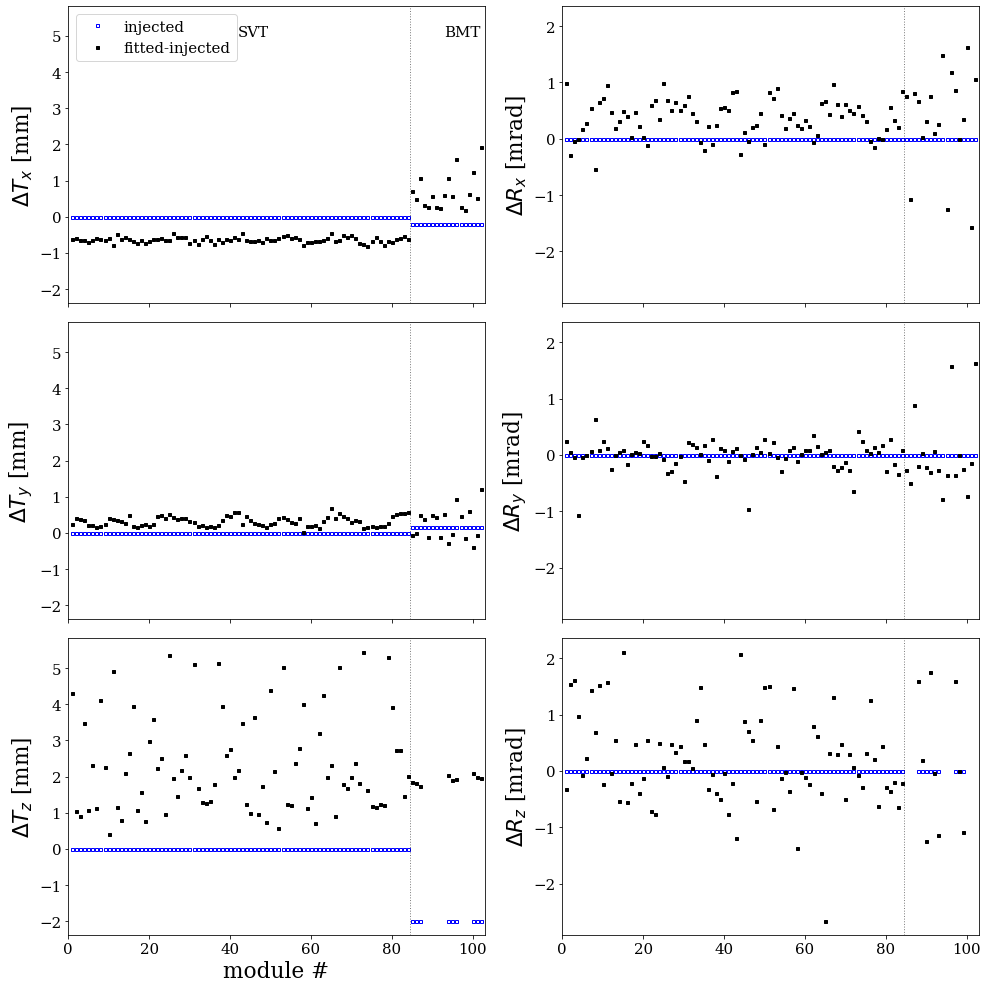

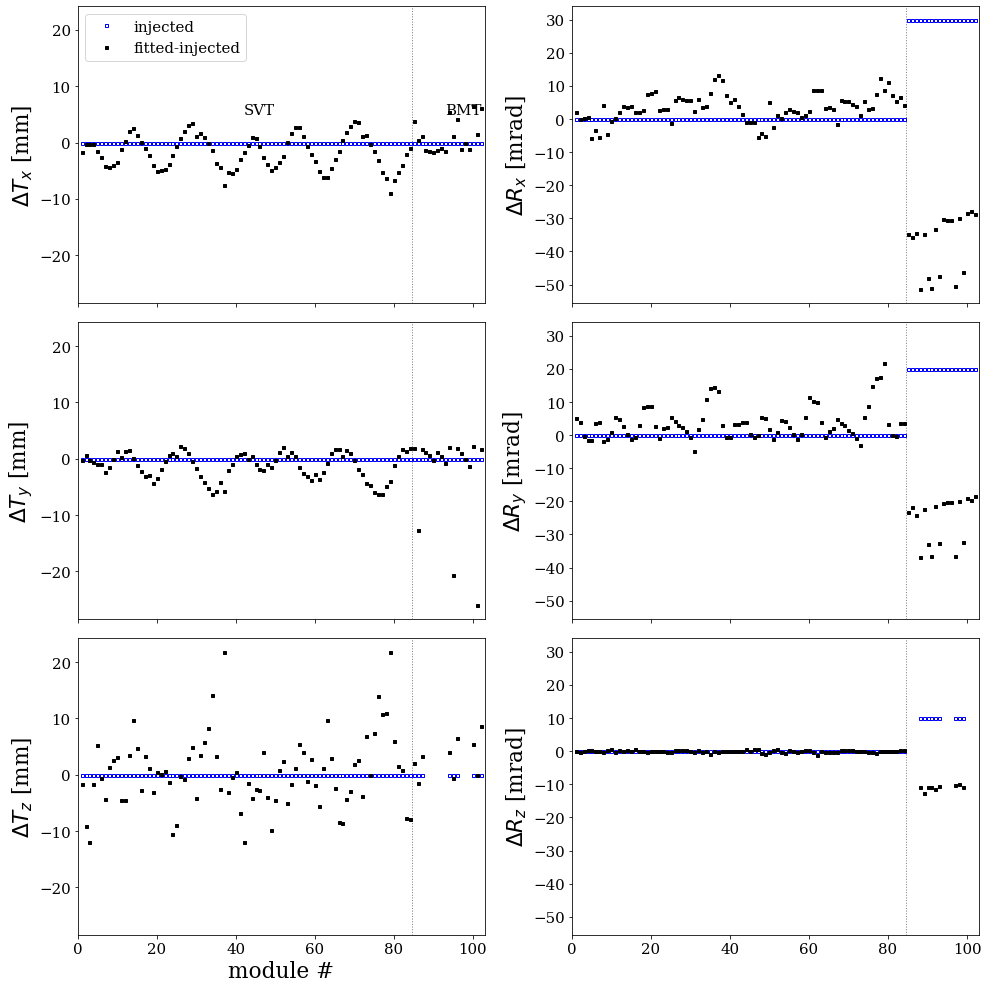

In [117]:
for a in "bmtshift bmtrotation".split():
    df_bmt_mc = get_df_from_file(f"/Users/spaul/alignment/clas12/scripts/mc/injection/mc_{a}_bmt.txt")
    df_bmt_fit = get_df_from_file(f"/Users/spaul/alignment/clas12/scripts/generic/cache2/mc_{a}/plots_pass_6/dev6_bmt.txt")


    df_svt_mc = get_df_from_file(f"/Users/spaul/alignment/clas12/scripts/mc/injection/mc_{a}_svt.txt")
    df_svt_fit = get_df_from_file(f"/Users/spaul/alignment/clas12/scripts/generic/cache2/mc_{a}/plots_pass_6/dev6_svt.txt")


    #df_svt_fit = get_df_from_ccdb("rga_fall2018_svtsurvey","/geometry/cvt/svt/layeralignment")

    injection_plot(df_svt_fit, df_bmt_fit, df_svt_mc, df_bmt_mc)

    plt.savefig(f"injection_{a}.png")
    plt.savefig(f"injection_{a}.pdf")
    plt.show()